# Stroke Risk Analysis

## 1. Project Background

Stroke is defined as a medical condition in which there is poor blood flow towards the brain, leading to cell death. The World Health Organization cites stroke as the 2nd leading cause of death globally, accounting for approximately 11% of total deaths. 

This project aims to build a predictive model to assess the likelihood of the onset of stroke of a patient using various potential parameters such as gender, age, medical history and smoking status. Ideally, the model should prioritise identifyingh high-risk patients while maintaining clinical practicality, ensuring that healthcare professionals can rely on the predictions for decision-making support.

The original data was obtained from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset). In order to simulate real-world data issues, the dataset has been purposefully augmented to include formatting inconsistencies, missing values, duplicate entries as well as invalid values. The augmented dataset can be viewed [here](../data/stroke_dataset_messy.csv).

This notebook focuses on the process of data cleaning as well as performing exploratory data analysis to analyse the target variables and its potential features, individually and how they interact with one another in order to shortlist the strongest predictors of stroke.

### Table of Contents

1. [Project Background](#1-project-background)
2. [Importing Packages](#2-importing-packages)
3. [Data Overview](#3-data-overview)
4. [Data Quality Assessment](#4-data-quality-assessment)
5. [Data Cleaning](#5-data-cleaning)

## 2. Importing Packages

In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from scipy.stats import chi2_contingency
from itertools import combinations

sys.path.append('..')
from src import standardize_capitalisation_and_spacing, impute_by_mode, impute_by_median

## 3. Data Overview

In [327]:
df_raw = pd.read_csv("../data/stroke_dataset_messy.csv")
df_raw.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,7885,Female,23.0,0,0,No,Private,Rural,92.26,17.1,Unknown,0
1,39120,FEMALE,82.0,0,0,No,Self-employed,Urban,82.21,26.0,never smoked,0
2,73740,male,26.0,0,0,No,Private,Urban,103.61,31.4,never smoked,0
3,14404,Female,13.0,0,0,NO,children,Urban,94.12,20.1,never smoked,0
4,73346,Female,25.5,NaN,No,NaN,Student,Urban,9999,0,,99
5,937,Male,7.0,0,0,No,children,Urban,87.94,NaN,Unknown,0
6,39308,Male,62.0,0,0,Yes,Private,City,145.37,33.3,UNKNOWN,0
7,2082,Male,35.0,0,0,Yes,Private,Rural,115.92,NaN,formerly smoked,0
8,46434,Male,52.0,1,0,Yes,Govt_job,Urban,214.43,39.9,smokes,0
9,48851,Female,9.0,0,0,No,children,Rural,77.67,17.6,?,0


In [328]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6029 entries, 0 to 6028
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 6029 non-null   int64 
 1   gender             5958 non-null   object
 2   age                5943 non-null   object
 3   hypertension       5880 non-null   object
 4   heart_disease      5887 non-null   object
 5   ever_married       5919 non-null   object
 6   work_type          5939 non-null   object
 7   Residence_type     5898 non-null   object
 8   avg_glucose_level  5902 non-null   object
 9   bmi                5613 non-null   object
 10  smoking_status     5921 non-null   object
 11  stroke             5901 non-null   object
dtypes: int64(1), object(11)
memory usage: 565.3+ KB


In [329]:
df_raw.describe()

,id
count,6029.000000
mean,42139.775751
std,23565.427945
min,67.000000
25%,21625.000000
50%,43454.000000
75%,64582.000000
max,73859.000000


In [330]:
df_raw.shape

(6029, 12)

### Conceptualising the Dataset

Each row of the dataset represents patient information and each patient is uniquely identified by their id. The most important column is `stroke`, which is the target variable for modelling. The other columns serve as potential features that may influence whether a patient is likely to have stroke or not. Some of these are demographics (age, gender, marital status, work type, residential type), medical history (hypertension, heart disease), lifestyle (smoking status) and clinical measurements (bmi, glucose level).


## 4. Data Quality Assessment

### Duplicate Value Analysis

In [331]:
num_dupes = int(df_raw.duplicated().sum())
print(f"Number of duplicate values: {num_dupes}")

Number of duplicate values: 0


There are no duplicate values in the dataset, which reinforces the uniqueness of the `id` column and that each id corresponds to a unique patient.

### Missing Value Analysis

                   Number of Missing Values  Proportion of Missing Values
bmi                                     416                          6.90
hypertension                            149                          2.47
heart_disease                           142                          2.36
Residence_type                          131                          2.17
stroke                                  128                          2.12
avg_glucose_level                       127                          2.11
ever_married                            110                          1.82
smoking_status                          108                          1.79
work_type                                90                          1.49
age                                      86                          1.43
gender                                   71                          1.18
id                                        0                          0.00


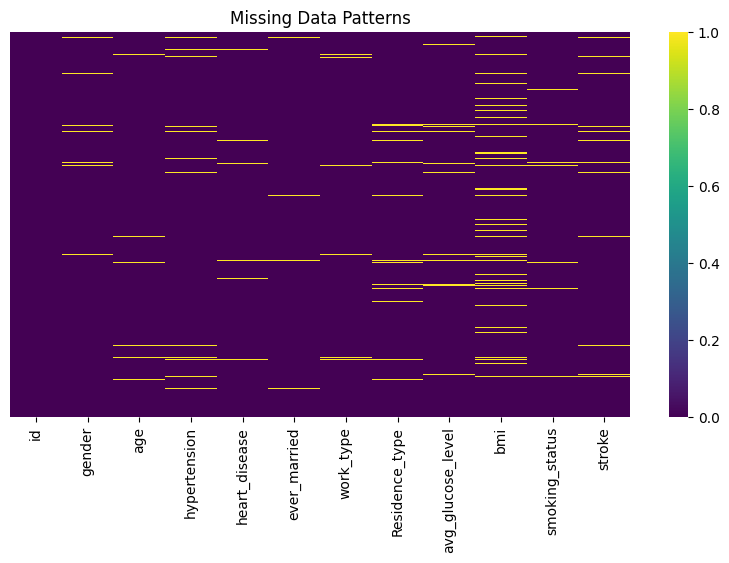

In [332]:
missing_values = pd.DataFrame({
    "Number of Missing Values": df_raw.isna().sum(),
    "Proportion of Missing Values": round(df_raw.isna().sum()/ len(df_raw) * 100, 2)})

print(missing_values.sort_values("Proportion of Missing Values", ascending= False))

plt.figure(figsize= (10,5))
sns.heatmap(df_raw.isnull(), yticklabels= False, cbar = True, cmap = 'viridis')
plt.title("Missing Data Patterns")
plt.show()

All columns except `id` contain missing values. While the proportion of missing values in each column is within reason (< 10%), the pattern of missing values requires careful examination before proceeding with exploratory data analysis.

The heatmap visualisation shows that missing values are missing completely at random, with scattered yellow lines (indicating missing values) and no thick horizontal or vertical bands in the chart. This means that there is no hidden bias in the missing values and the missing values can be addressed either through deletion or imputation.

The following columns: `bmi`, `heart_disease`, `hypertension`, `stroke` are of concern as the proportion of missing values exceed 5% and require more careful handling during the data cleaning stage.

### Formatting Analysis

In [333]:
df_raw["gender"].unique()
df_raw["age"].unique()
df_raw["hypertension"].unique()
df_raw["heart_disease"].unique()
df_raw["ever_married"].unique()
df_raw["work_type"].unique()
df_raw["Residence_type"].unique()
df_raw['avg_glucose_level'].unique()
df_raw["bmi"].unique()
df_raw["smoking_status"].unique()
df_raw["stroke"].unique()

array(['0', '99', '1', nan, 'No', 'Unknown', '2', '-1', 'Yes'],
      dtype=object)

Investigation of the values in each of these fields found multiple errors that need to be addressed during the data cleaning stage.

**Membership Constraints in Categorical Columns**: Categorical columns (`gender`, `hypertension`, `heart_disease`, `ever_married`, `work_type`, `Residence_type`, `smoking_status`, `stroke`) contain invalid values that do not fit into the assigned categories listed in the data card. Additionally, there are many similar entries that are assigned as different categories because of differing capitalisation and spacings.

**Formatting Inconsistencies in Numerical Columns**: Numeric columns contain units of measurements (e.g. 23.1 kg/m2) and irregular decimal formatting ('4.0.0').

**Invalid Values in Numerical Columns**: Some values in the `age` column are deemed invalid as they are below 0 and above 100. There are also float values which need to be rounded down so that the values in the column are discrete numeric values. The same errors can be found in the `bmi` column which contain string values (e.g. "Obese"), negative errors and extreme values (> 50).

**Wrong Column Types**: Columns in the dataset are not properly formatted into the correct data types to be consistent to their values.

## 5. Data Cleaning

### Addressing Formatting Inconsistencies

In [334]:
df_copy = df_raw.copy()

standardize_capitalisation_and_spacing(df_copy)

Trailing spaces were removed from all columns, and all string values have been converted to lower case, with the first letter capitalised. This is to ensure consistent spelling and categorization especially for categorical columns to collapse as many categories together that may have been otherwise separated.

#### Categorical Columns

In [335]:
#df_copy["gender"].unique()

gender_mapping = {
    'F': 'Female',
    'Woman': 'Female',
    
    'M': 'Male',
    'Man': 'Male',

    'Non-binary': 'Other',

    'Prefer not to say': np.nan,
    'Nan': np.nan,
    '': np.nan,
    '?': np.nan,
    'Unknown': np.nan
}

df_copy['gender'] = df_copy['gender'].replace(gender_mapping)
df_copy["gender"] = df_copy["gender"].astype("category")
df_copy["gender"].unique()


['Female', 'Male', NaN, 'Other']
Categories (3, object): ['Female', 'Male', 'Other']

In [336]:
#df_copy["hypertension"].unique()

hypertension_mapping = {
    'Yes': '1',

    'No': '0',

    '2': np.nan,
    'Nan': np.nan,
    '-1': np.nan,
    'Unknown': np.nan,
    '99': np.nan

}

df_copy['hypertension'] = df_copy['hypertension'].replace(hypertension_mapping)
df_copy["hypertension"] = df_copy["hypertension"].astype("category")
df_copy["hypertension"].unique()

['0', NaN, '1']
Categories (2, object): ['0', '1']

In [337]:
#df_copy["heart_disease"].unique()

heart_disease_mapping = {
    'Yes': '1',

    'No': '0',

    '2': np.nan,
    'Nan': np.nan,
    '-1': np.nan,
    'Unknown': np.nan,
    '99': np.nan

}

df_copy['heart_disease'] = df_copy['heart_disease'].replace(heart_disease_mapping)
df_copy["heart_disease"] = df_copy["heart_disease"].astype("category")
df_copy["heart_disease"].unique()

['0', '1', NaN]
Categories (2, object): ['0', '1']

In [338]:
#df_copy["ever_married"].unique()

marital_mapping = {
    'True': 'Yes',
    'Divorced': 'Yes',
    'Married': 'Yes',
    'Y': 'Yes',

    'False': 'No',
    'N': 'No',
    'Single': 'No',

    'Unknown': np.nan,
    '': np.nan,
    'Nan': np.nan
    
}

df_copy["ever_married"] = df_copy['ever_married'].replace(marital_mapping)
df_copy["ever_married"] = df_copy["ever_married"].astype("category")
df_copy["ever_married"].unique()

['No', NaN, 'Yes']
Categories (2, object): ['No', 'Yes']

In [339]:
#df_copy['work_type'].unique()

work_mapping = {
    "Private sector": "Private",

    "Child": 'Children',
    "Student": 'Children',

    "Government": "Govt_job",
    "Public sector": "Govt_job",

    "Retired": "Never_worked",
    "Unemployed": 'Never_worked',
    "Never worked": "Never_worked",

    "Freelance": "Self-employed",
    "Self employed": "Self-employed",

    "Unknown": np.nan,
    "Nan": np.nan
}

df_copy["work_type"] = df_copy["work_type"].replace(work_mapping)
df_copy["work_type"] = df_copy["work_type"].astype("category")
df_copy["work_type"].unique()

['Private', 'Self-employed', 'Children', 'Govt_job', NaN, 'Never_worked']
Categories (5, object): ['Children', 'Govt_job', 'Never_worked', 'Private', 'Self-employed']

In [340]:
#df_copy["Residence_type"].unique()

residence_mapping ={
    
    'Village': 'Rural',

    'City': 'Urban',
    'Suburban': 'Urban',

    'Nan': np.nan,
    'Unknown': np.nan,
    '': np.nan

}

df_copy["Residence_type"] = df_copy["Residence_type"].replace(residence_mapping)
df_copy["Residence_type"] = df_copy["Residence_type"].astype("category")
df_copy["Residence_type"].unique()

['Rural', 'Urban', NaN]
Categories (2, object): ['Rural', 'Urban']

In [341]:
#df_copy['smoking_status'].unique()

smoking_mapping = {

    "Nan": "Unknown",
    "Not known": "Unknown",
    '?': "Unknown",
    '': 'Unknown',

    "Never_smoked": "Never smoked",
    "Non-smoker": "Never smoked",

    "Ex-smoker": "Formerly smoked",
    "Formerly_smoked": "Formerly smoked",

    "Current smoker": "Smokes",
    "Smoker": "Smokes",

}

df_copy["smoking_status"] = df_copy['smoking_status'].replace(smoking_mapping)
df_copy["smoking_status"] = df_copy["smoking_status"].astype("category")
df_copy['smoking_status'].unique()

['Unknown', 'Never smoked', 'Formerly smoked', 'Smokes']
Categories (4, object): ['Formerly smoked', 'Never smoked', 'Smokes', 'Unknown']

In [342]:
#df_copy["stroke"].unique()

stroke_mapping = {

    'Yes': '1',

    'No': '0',

    'Nan': np.nan,
    "2": np.nan,
    '-1': np.nan,
    'Unknown': np.nan,
    '99': np.nan

}

df_copy["stroke"] = df_copy['stroke'].replace(stroke_mapping)
df_copy["stroke"] = df_copy["stroke"].astype("category")
df_copy["stroke"].unique()

['0', NaN, '1']
Categories (2, object): ['0', '1']

To ensure consistency across categorical variables, inconsistent entries were cleaned by mapping similar values to standardized categories in the data card. Entries with spelling inconsistencies and shorthand notations were mapped to their correct forms. Empty or invalid values were replaced with nan values.

`hypertension`, `heart_disease` & `stroke`: These columns only accept binary values ("0" for absence of disease, "1" for presence of disease). Values like "Yes" and "No" were mapped to "1" and "0" respectively. Entries labelled "Unknown" and out-of-range numeric values ("2", "-1" & "99") are ambiguous and not indicative of the presence or absence of disease, and were converted to nan values.

`gender`: Gender values belong to one of three classes: "Male", "Female", and "Other". Shorthand notations and nouns referring to gender identity were mapped to their corresponding classes ("F" and "Woman" to "Female", "M" and "Man" to "Male"). Entries labelled "Non-binary" were mapped to "Other" as they do not fit into the typical "Male" and "Female" category. The remaining entries ("", "?", "Unknown", "Prefer not to say") were ambiguous and converted to nan values as they cannot be reliably classified into any of the three categories.

`ever_married`: This column only accepts 'Yes' or 'No' values. Entries indicating a current or previous marital status ('True', "Divorced", "Married", "Y") were mapped to "Yes" and those indicating that patients were never married ("Single", "False", "N") were mapped to "No". Missing and unknown values were converted to nan.

`work_type`: Work type categories were consolidated into their standardized groups. Employment-related entries were mapped as follows: "Private sector" to "Private", government-related work ("Government", "Public sector") to "Govt_job", and self-employed variants ("Freelance", "Self employed") to "Self-employed". Non-working individuals were grouped by category: dependents ("Child", "Student") were mapped to "Children", while those not in the workforce ("Retired", "Unemployed", "Never worked") were mapped to "Never_worked". Unknown entries were converted to nan.

`Residence_type`: The type of residence can only be classified as either "Rural" or "Urban". Entries indicating more remote living ("Village") were mapped to "Rural", and those indicating a more developed area ("City", "Suburban") were mapped to "Urban". Unknown and missing entries were converted to nan. 

`smoking_status`: Smoking status values were standardized into their consistent categories. Current smoking indicators ("Current smoker", "Smoker") were mapped to "Smokes", past smoking history ("Ex-smoker", "Formerly_smoked") were mapped to "Formerly smoked", and non-smoking indicators ("Never_smoked", "Non-smoker") were mapped to "Never smoked". Ambiguous and missing entries were mapped to "Unknown".

All columns were then converted to the category type.

#### Numeric Columns

In [343]:
#df_copy["age"].unique()

df_copy['age'] = df_copy['age'].str.replace(r'\.0\.0$', '.0', regex=True)
df_copy['age'] = df_copy['age'].str.replace(r'\.0+$', '', regex=True)  
df_copy["age"] = df_copy["age"].replace(["Unknown", "Nan"], np.nan)
df_copy['age'] = df_copy['age'].replace("Thirty", "30")

df_copy['age'] = df_copy['age'].astype("float")
df_copy.loc[(df_copy["age"] < 0) | (df_copy["age"] > 100), "age"] = np.nan
df_copy['age'] = df_copy['age'].round().astype("Int64")
df_copy["age"].unique()

<IntegerArray>
[  23,   82,   26,   13,    7,   62,   35,   52,    9,   68,   47,   81,   20,
   12,   53,   54,   30,   66,    2,    5,   50,   73,   36,   55,   58,    0,
 <NA>,   78,    6,   61,   18,   65,   79,   59,   43,   34,   67,   60,   70,
   21,   44,   17,   80,   27,   40,   72,    3,   22,    1,   31,   45,   32,
   38,   75,   28,   37,   39,   69,   16,   51,    8,   42,   77,   46,   15,
   29,   63,   57,   19,   41,   33,   14,   76,   11,   56,   24,   49,   25,
   74,   71,   64,   10,   48,   93,    4,   91,   88,   83,   86,   90]
Length: 90, dtype: Int64

In [344]:
#df_copy["avg_glucose_level"].unique()

invalid_values = ["Normal", "High"]
df_copy['avg_glucose_level'] = df_copy['avg_glucose_level'].replace(invalid_values, np.nan)
df_copy['avg_glucose_level'] = df_copy['avg_glucose_level'].str.replace(r'\s*mg/dl\s*', '', regex=True, case=False)

df_copy["avg_glucose_level"] = df_copy["avg_glucose_level"].astype("float")
df_copy.loc[(df_copy["avg_glucose_level"] < 50.0) | (df_copy["avg_glucose_level"] > 600.0), "avg_glucose_level"] = np.nan
df_copy["avg_glucose_level"].unique()

array([ 92.26      ,  82.21      , 103.61      , ..., 259.69283478,
       265.6701202 , 100.15      ], shape=(4060,))

In [345]:
df_copy["bmi"].unique()

invalid_values = ["Normal", "Obese", "Unknown", "N/a", "Nan", ""] 
df_copy['bmi'] = df_copy['bmi'].replace(invalid_values, np.nan)
df_copy['bmi'] = df_copy['bmi'].str.replace(r'\s*kg/m²\s*', '', regex=True, case=False)

df_copy["bmi"] = pd.to_numeric(df_copy['bmi'], errors='coerce')
df_copy.loc[(df_copy["bmi"] < 12) | (df_copy["bmi"] > 60), "bmi"] = np.nan
df_copy["bmi"] = df_copy["bmi"].round(1)

df_copy["bmi"].unique()

array([17.1, 26. , 31.4, 20.1,  nan, 33.3, 39.9, 17.6, 31.3, 50.1, 29.4,
       27.3, 37.3, 29.3, 30.3, 28. , 25.3, 18.6, 31.9, 22.7, 32.2, 21.3,
       34.7, 25.5, 25.8, 32.4, 16.2, 29.8, 18.9, 28.5, 23.6, 22.2, 33.5,
       25.1, 45.9, 30. , 34.8, 31.5, 26.9, 24.1, 30.1, 23.2, 30.8, 36.4,
       26.3, 27.7, 31.8, 25.6, 26.8, 41.6, 29.5, 39.1, 35. , 28.7, 17.7,
       40. , 18.2, 30.4, 41.8, 15.1, 26.6, 27.9, 41.1, 18.3, 23.1, 37.6,
       31.1, 21.9, 34.3, 16.3, 38.3, 25.9, 23.9, 14.1, 18.1, 24. , 38.6,
       29.1, 23.8, 26.2, 40.3, 42.4, 18.5, 24.3, 21.2, 28.4, 32.5, 31.6,
       39.6, 21.4, 22.8, 20.3, 35.1, 54. , 24.7, 18. , 42.2, 25.4, 21.8,
       35.4, 30.9, 17. , 43. , 26.1, 30.7, 36.6, 29. , 23. , 23.3, 21.7,
       44.1, 27.6, 25.2, 41.9, 38.1, 24.2, 17.9, 19.2, 48.2, 32.1, 35.8,
       29.6, 32.7, 41.2, 40.5, 16. , 33.2, 22.1, 34.5, 27.8, 19.6, 45.4,
       19.7, 36.7, 48.3, 19.8, 21. , 52.3, 32.3, 28.8, 17.4, 36.1, 32.8,
       30.5, 32.9, 16.1, 23.5, 49.8, 34.1, 29.9, 33

The numeric columns contained inconsistent formatting, irregular decimal points, irrelevant descriptors and string values, which were removed during the cleaning process. After standardizing the formats, the values were typecasted into appropriate numeric types. Invalid entries and extreme outliers were then converted to nan for consistency.

`age`: Decimal points with trailing zeros("0.0" and ".0") were removed from age entries. String representations of numeric values were converted to their numerical forms ("Thirty" -> "30"), and missing values ("Unknown", "Nan") were converted to nan. Invalid age values like below 0 and above 100 were also replaced with nan and the subsequent data values were rounded off before converted to the integer subtype.

`avg_glucose_level`: Units of measurement (mg/dl) were removed from the entries to only retain numeric data. String values that do not accurately pinpoint a clinical measurement ("Normal", "High") were replaced with nan, as well as clinically invalid glucose measurements (below 50 and above 600). The cleaned values were then converted to the float subtype.

`bmi`: Units of measurement (kg/m²) were removed form the entries. String values do not provide a numerical value ("Normal", "Obese") were replaced with nan, as well as inplausible BMI measurements (below 12 and above 60). The remaining BMI values were then converted to the float subtype, rounded off to 1 decimal place.

### Addressing Missing Values

In [346]:
missing_values = pd.DataFrame({
    "Num_Missing": df_copy.isnull().sum(),
    "Prop_Missing": round(df_copy.isnull().sum() / len(df_copy) * 100,2)
})

print(missing_values.sort_values("Prop_Missing", ascending= False))

                   Num_Missing  Prop_Missing
bmi                        761         12.62
avg_glucose_level          419          6.95
heart_disease              332          5.51
hypertension               329          5.46
stroke                     319          5.29
age                        298          4.94
gender                     216          3.58
Residence_type             210          3.48
ever_married               175          2.90
work_type                  122          2.02
id                           0          0.00
smoking_status               0          0.00


In [347]:
# Dropping Missing Values
cols_to_drop = ['work_type', 'ever_married', 'Residence_type', 'gender', 'age', 'stroke']
df_copy.dropna(subset = cols_to_drop, inplace= True)

# Imputing Missing Values
impute_by_median(df_copy, "bmi", "avg_glucose_level")
impute_by_mode(df_copy, "heart_disease", "hypertension")

Imputed missing values for column: bmi
Imputed missing values for column: avg_glucose_level
Imputed missing values for column: heart_disease
Imputed missing values for column: hypertension


The missing values in `work_type`, `ever_married`, `Residence_type`, `gender` and `age` columns were dropped as they only accounted for less than 5% of the entire dataset and would not lead to significant loss of data. The missing values from the `stroke` column were dropped, as imputation of the target variable might introduce bias in the modelling prediction.

For the missing values in the `bmi` and `avg_glucose_level` columns, they were imputed by filling in the median value of these columns. The missing values in the `heart_disease` and `hypertension` columns were imputed with the modal value in these columns, which is appropriate for binary categorical variables.

### Final Validation and Quality Check

In [348]:
missing_values = pd.DataFrame({
    "Num_Missing": df_copy.isnull().sum(),
    "Prop_Missing": round(df_copy.isnull().sum() / len(df_copy) * 100,2)
})

print(missing_values.sort_values("Prop_Missing", ascending= False))

                   Num_Missing  Prop_Missing
id                           0           0.0
gender                       0           0.0
age                          0           0.0
hypertension                 0           0.0
heart_disease                0           0.0
ever_married                 0           0.0
work_type                    0           0.0
Residence_type               0           0.0
avg_glucose_level            0           0.0
bmi                          0           0.0
smoking_status               0           0.0
stroke                       0           0.0


In [349]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5527 entries, 0 to 6028
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5527 non-null   object  
 1   gender             5527 non-null   category
 2   age                5527 non-null   Int64   
 3   hypertension       5527 non-null   category
 4   heart_disease      5527 non-null   category
 5   ever_married       5527 non-null   category
 6   work_type          5527 non-null   category
 7   Residence_type     5527 non-null   category
 8   avg_glucose_level  5527 non-null   float64 
 9   bmi                5527 non-null   float64 
 10  smoking_status     5527 non-null   category
 11  stroke             5527 non-null   category
dtypes: Int64(1), category(8), float64(2), object(1)
memory usage: 265.6+ KB


In [350]:
df_copy.describe()

,age,avg_glucose_level,bmi
count,5527.0,5527.000000,5527.000000
mean,43.123394,106.186945,28.797539
std,22.612808,45.315953,7.327991
min,0.0,55.120000,12.000000
25%,25.0,77.190000,23.900000
50%,45.0,91.865000,28.100000
75%,61.0,114.285000,32.600000
max,82.0,271.740000,59.700000


In [351]:
#Exporting Cleaned CSV

df_cleaned = df_copy

os.makedirs("../data", exist_ok= True)
df_cleaned.to_csv("../data/stroke_dataset_cleaned.csv")